<h1><b><span style="color: #e56b6f; font-size: 28px">IMPORTING LIBRARIES</span></b></h1>


In [25]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import re
from wordcloud import WordCloud
from collections import Counter
from geopy.geocoders import ArcGIS
import folium


# Preprocessing and evaluation
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

pd.set_option('display.max_colwidth', 500)
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')




[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

<h1><b><span style="color: #e56b6f; font-size: 28px">DATA LOADING</span></b></h1>


## Helper Function

In [2]:
class CleanTweet():
    '''
    Remove non-english characters and newline char
    Remove numbers, hyperlink, mentions and hashtags
    '''
    def __init__(self, pattern):
        self.pattern = pattern

    def __call__(self, text):
        if isinstance(text, str):
            tweet = text

        tweet = re.sub(self.pattern, '', tweet)

        return tweet

clean = CleanTweet(r'(\n+)|([0-9])|(#?\s?[^\u0000-\u05C0\u2100-\u214F]+)|'
                   r'(#[A-Za-z0-9]+)|(https?:\/\/.*[\r\n]*)|(@[A-Za-z0-9]+)')

def cleanLemmatize(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

def plotWordCloud(df, title):
    '''
    Word Cloud
    '''
    wc = WordCloud(max_words=1000, min_font_size=10,
                    height=800,width=1600,background_color="white",
                    colormap='flare').generate(' '.join(df['Cleaned Tweet']))
    plt.figure(1, figsize=(15, 15))
    plt.title(title)
    plt.axis('off')
    plt.imshow(wc)

def getSentiment(tweet):

    '''
    get tweet sentiment
    '''

    def getPolarity(tweet):
        return TextBlob(tweet).sentiment.polarity

    polarity = getPolarity(tweet)

    if polarity > 0:
        sentiment = 'Positive'

    elif polarity == 0:
        sentiment = 'Neutral'

    else:
        sentiment = 'Negative'

    return sentiment

def dfInfo(df,name):
    negative = df[df.sentiment == 0].shape[0]
    neutral = df[df.sentiment == 1].shape[0]
    positive = df[df.sentiment == 2].shape[0]

    print(f"\n{name} -----> shape : {df.shape}")
    print(f"{name} -----> negative: {negative}, neutral: {neutral}, positive: {positive}\n")

    return None

In [3]:

new_df = pd.read_csv('processed_data.csv')
new_df.head()

,text,sentiment
0,come ask leave house sunday live eviction show move white room,2
1,gonna lie big brother mess isnt fair even fan,2
2,production team doesnt care bite people mental health sad cant begin imagine whats go head right whos military already battle anxiety,0
3,kayode one responsible show bore hms,2
4,video s fan protest bbnaijas eviction twist lagos,1


In [4]:
train, test = train_test_split(new_df, test_size = 0.2, shuffle=True)

dfInfo(train, 'train')
dfInfo(test, 'validation')

train_x, train_y = train['text'], train['sentiment']

test_x, test_y = test['text'], test['sentiment']


train -----> shape : (15284, 2)
train -----> negative: 2197, neutral: 7021, positive: 6066


validation -----> shape : (3822, 2)
validation -----> negative: 562, neutral: 1729, positive: 1531



In [5]:
train_y

7953     0
10888    0
8613     0
18532    2
4779     2
        ..
7045     1
2960     1
724      0
8469     2
18968    1
Name: sentiment, Length: 15284, dtype: int64

In [6]:
from sklearn.preprocessing import OneHotEncoder
train_y = OneHotEncoder().fit_transform(np.array(train_y).reshape(-1, 1))
test_y = OneHotEncoder().fit_transform(np.array(test_y).reshape(-1, 1))


In [7]:
train_y.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

<h1><b><span style="color: #e56b6f; font-size: 28px">MODEL BUILDING</span></b></h1>


<h1><b><span style="color: #e56b6f; font-size: 20px">LSTM</span></b></h1>


In [8]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_x.astype('str'))
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(train_x.astype('str'))
train_padded = pad_sequences(train_seq, maxlen=50, padding='post')

test_seq = tokenizer.texts_to_sequences(test_x.astype('str'))
test_padded = pad_sequences(test_seq, maxlen=50, padding='post')

Total distinct words: 14127


In [9]:
train_padded.shape

(15284, 50)

In [10]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [11]:
def LSTM():

    from keras.constraints import max_norm


    model = tf.keras.models.Sequential([
                tf.keras.layers.Embedding(50000,128,input_length=train_padded.shape[1]),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.LSTM(32,kernel_constraint=max_norm(3)),
                tf.keras.layers.Dense(32,activation='relu',kernel_regularizer=l2(0.01)),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(3,activation='softmax')
            ])

    print(model.summary())

    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_padded, train_y.toarray(), epochs=25, validation_data=(test_padded, test_y.toarray()))

    return model


In [12]:
model = LSTM()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 128)           6400000   
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 6421763 (24.50 MB)
Trainable params: 64217

<Axes: >

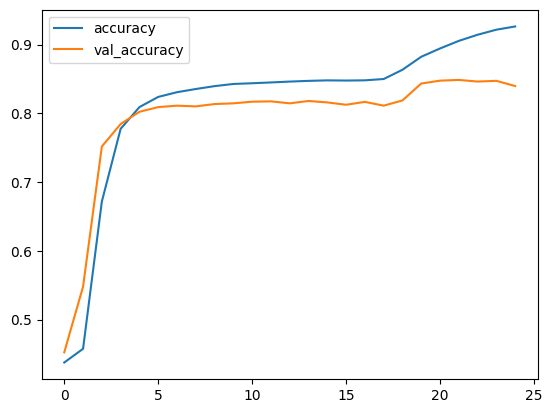

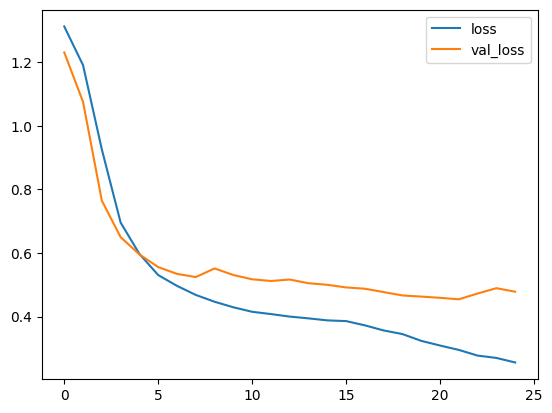

In [13]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [14]:
test_acc = model.evaluate(test_padded, test_y.toarray())
print("Testing Accuracy(%): ", test_acc[1]*100)



120/120 [==============================] - 0s 4ms/step - loss: 0.4785 - accuracy: 0.8396
Testing Accuracy(%):  83.96127820014954


In [15]:
y_pred = model.predict(test_padded)
y_predicted_labels = np.array([ np.argmax(i) for i in y_pred])
y_test_labels = np.array([ np.argmax(i) for i in test_y.toarray()])

120/120 [==============================] - 1s 3ms/step


In [16]:
np.unique(y_predicted_labels)

array([0, 1, 2])

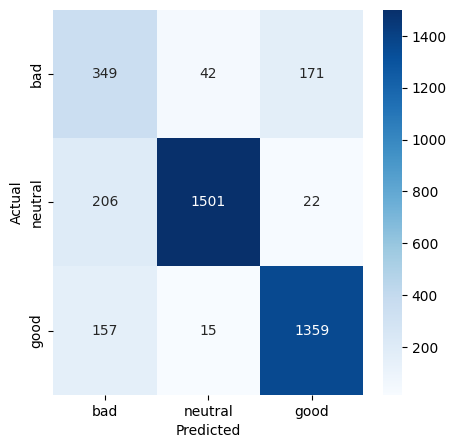

In [17]:
import seaborn as sn
cm = confusion_matrix(y_test_labels, y_predicted_labels)
labels=["bad", "neutral", "good"]
plt.figure(figsize=(5,5))
sn.heatmap(cm,  xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
model.save('sentiment_model-lstm.h5')

<h1><b><span style="color: #e56b6f; font-size: 28px">PREDICTION</span></b></h1>


In [27]:
!pip install colorama
from colorama import Fore


In [30]:
# Deep Neural Network
def dl_predict(text):
    clean_text = cleanLemmatize(text)
    seq = tokenizer.texts_to_sequences([str(clean_text)])
    padded = pad_sequences(seq, maxlen=50, padding='post')

    pred = model.predict(padded).argmax(1)[0]

    if pred == 0:
        sentiment = Fore.RED +'Negative'

    elif pred == 1:
        sentiment = Fore.BLACK + 'Neutral'

    else:
        sentiment = Fore.GREEN + 'Positive'

    print(text + ' is a ' + sentiment + ' tweet ')

    # return pred

In [32]:
text = 'Such a comfy place to stay with the loved one'

dl_predict(text)

1/1 [==============================] - 0s 103ms/step
Such a comfy place to stay with the loved one is a Positive tweet 
